<a href="https://colab.research.google.com/github/harrymkwn/InfluenceAnalysis/blob/master/AllEmointMod.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
import pandas as pd
import numpy as np
import tensorflow as tf
from gensim.models import Word2Vec
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from gensim.models import KeyedVectors
from sklearn.model_selection import train_test_split
from google.colab import  drive
drive.mount('/content/drive')
import nltk
from nltk.corpus import stopwords
nltk.download('all')
device_name = tf.test.gpu_device_name()
print(device_name)
df = pd.read_csv('/content/drive/MyDrive/InfluenceAnalysis/Data/Tweets_clean_data.csv')
df = df.sample(frac=1)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/biocreative_ppi.zip.
[nltk_data]    | Downloading package brown to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/brown.zip.
[nltk_data]    | Downloading package brown_tei to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/brown_tei.zip.
[nltk_data]    | Downloading package cess_cat to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cess_cat.zip.
[nltk_data]    | Downloading package cess_esp to /root/nltk_data...
[nltk_data]  

In [21]:
category_dict = {"anger":[1,0,0,0],"sadness":[0,1,0,0],"fear":[0,0,1,0],"joy":[0,0,0,1]}
data_tweet = [x.lower().split() for x in df['Tweet']]
data_cat = np.array([category_dict[x] for x in df['Emotion']])

In [22]:
print(data_tweet[:5])
print(data_cat[:5])

[['i', 'thought', 'it', 'was', 'because', 'she', 'once', 'sunk', 'her', 'teeth', 'into', 'something', 'that', 'is', 'meant', '2b', 'soked'], ['answers', 'i', 'have', 'contacted', 'answers', 'service', 'whathappenedtocustomerservice'], ['who', 'knew', 'softballs', 'could', 'sting', 'so', 'bad', 'jimmy', 'fallon', 'has', 'been', 'under', 'a', 'lot', 'of', 'heat', 'for', 'his', 'andldquo', 'softballandrdquo', 'donald', 'trump', 'interview'], ['resent'], ['so', 'going', 'to', 'local', 'news', 'immediately', 'after', 'designated', 'survivor', 'turns', 'out', 'to', 'be', 'a', 'smooth', 'transition', 'chaos', 'a', 'raging', 'fire', 'media']]
[[0 1 0 0]
 [0 0 1 0]
 [1 0 0 0]
 [1 0 0 0]
 [0 0 1 0]]


In [23]:
# Parameters
Min_count = 0
Embedding_size = 100
Window_size = 5
Negative_sampling = 00

In [24]:
w2v_sg = Word2Vec(min_count=Min_count,
                     window=Window_size,
                     size=Embedding_size,
                     negative=Negative_sampling,sg=1)
w2v_sg.build_vocab(data_tweet)
w2v_sg.train(data_tweet, total_examples=w2v_sg.corpus_count, epochs=5)
w2v_cbow = Word2Vec(min_count=Min_count,
                     window=Window_size,
                     size=Embedding_size,
                     negative=Negative_sampling,sg=0)
w2v_cbow.build_vocab(data_tweet)
w2v_cbow.train(data_tweet, total_examples=w2v_cbow.corpus_count, epochs=5)
w2v_sg.wv.init_sims(True)
w2v_cbow.wv.init_sims(True)

In [25]:
vocab_sg = w2v_sg.wv.vocab
vocab_sg = [x for x in vocab_sg]
vocab_cbow = w2v_cbow.wv.vocab
vocab_cbow = [x for x in vocab_cbow] 
vocab_glove = {}
with open("/content/drive/My Drive/InfluenceAnalysis/glove/glove.twitter.27B.100d.txt", 'r', encoding="utf-8") as f:
  for line in f:
      values = line.split()
      word = values[0]
      vector = np.asarray(values[1:], "float32")
      vocab_glove[word] = vector

In [26]:
batch_size = 100
Max_input_size = max([len(x) for x in data_tweet])
mul_factor=1.5

In [28]:
X_train, X_test, y_train, y_test = train_test_split(data_tweet, data_cat, test_size=0.30, random_state=42)
X_train = [nltk.pos_tag(x) for x in X_train]
X_test = [nltk.pos_tag(x) for x in X_test]
result_table = [0,0,0,0,0,0,0,0,0]

In [30]:
def vec_gen(w2v,vocab,data_tweet,data_cat,batch_size,Max_input_size,Embedding_size,mul_factor):
  while True:
    for k in range(int(len(data_tweet)/batch_size)):
      res=[]
      for x in data_tweet[k*(batch_size):(k+1)*(batch_size)]:
        tweet = [(w2v.wv.word_vec(i[0]),i[1]) for i in x if i[0] in vocab]
        l=len(tweet)
        for i in range(l):
          if tweet[i][1][:2]=='JJ' or tweet[i][1][:2]=='NN' or tweet[i][1][:2]=='RB' or tweet[i][1][:2]=='VB':
            tweet[i]=((tweet[i][0])*mul_factor,tweet[i][1])
        res+=[np.array([x[0] for x in tweet])]
      temp = np.array([np.pad(z.flatten(),(0,Max_input_size*Embedding_size-len(z.flatten()))).reshape(Max_input_size,Embedding_size) for z in res])
      tempres = data_cat[k*(batch_size):(k+1)*(batch_size)]
      yield (temp,tempres)          
      
def glove_gen(vocab,data_tweet,data_cat,batch_size,Max_input_size,Embedding_size,mul_factor):
  while True:
    for k in range(int(len(data_tweet)/batch_size)):
      res=[]
      for x in data_tweet[k*(batch_size):(k+1)*(batch_size)]:
        tweet = [(vocab[i[0]],i[1]) for i in x if i[0] in vocab.keys()]
        l=len(tweet)
        for i in range(l):
          if tweet[i][1][:2]=='JJ' or tweet[i][1][:2]=='NN' or tweet[i][1][:2]=='RB' or tweet[i][1][:2]=='VB':
            tweet[i]=((tweet[i][0])*mul_factor,tweet[i][1])
        res+=[np.array([x[0] for x in tweet])]
      temp = np.array([np.pad(z.flatten(),(0,Max_input_size*Embedding_size-len(z.flatten()))).reshape(Max_input_size,Embedding_size) for z in res])
      tempres = data_cat[k*(batch_size):(k+1)*(batch_size)]
      yield (temp,tempres)

In [31]:
epochs = 50

In [32]:
model_sg = tf.keras.Sequential()
model_sg.add(tf.keras.Input(shape=(Max_input_size,Embedding_size)))
model_sg.add(tf.keras.layers.LSTM(50))
model_sg.add(tf.keras.layers.Dense(4, activation='softmax'))
model_sg.compile(loss='categorical_crossentropy',optimizer='adam', 
                           metrics=['accuracy'])
history_sg_lstm = model_sg.fit_generator(generator = vec_gen(w2v_sg,vocab_sg,X_train,y_train,batch_size,Max_input_size,Embedding_size,mul_factor),steps_per_epoch=int(len(X_train)/batch_size),epochs=epochs)
history = model_sg.evaluate(x = vec_gen(w2v_sg,vocab_sg,X_test,y_test,batch_size,Max_input_size,Embedding_size,mul_factor),steps=int(len(y_test)/batch_size))
print(history)

result_table[0]=history[1]
print("SG_LSTM")


Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/50
49/49 [==============================] - 3s 65ms/step - loss: 1.3765 - accuracy: 0.3190
Epoch 2/50
49/49 [==============================] - 3s 65ms/step - loss: 1.3735 - accuracy: 0.3216
Epoch 3/50
49/49 [==============================] - 3s 64ms/step - loss: 1.3734 - accuracy: 0.3216
Epoch 4/50
49/49 [==============================] - 3s 66ms/step - loss: 1.3732 - accuracy: 0.3216
Epoch 5/50
49/49 [==============================] - 3s 67ms/step - loss: 1.3639 - accuracy: 0.3363
Epoch 6/50
49/49 [==============================] - 3s 67ms/step - loss: 1.3427 - accuracy: 0.3637
Epoch 7/50
49/49 [==============================] - 3s 67ms/step - loss: 1.3345 - accuracy: 0.3704
Epoch 8/50
49/49 [==============================] - 3s 65ms/step - loss: 1.3204 - accuracy: 0.3859
Epoch 9/50
49/49 [==============================] - 3s 65ms/step - loss: 1.3160 - accuracy: 0.3914
Epoch 10/50
49/49 [==============

In [35]:
model_sg_bi = tf.keras.Sequential()
model_sg_bi.add(tf.keras.Input(shape=(Max_input_size,Embedding_size)))
model_sg_bi.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(50),merge_mode='concat'))
model_sg_bi.add(tf.keras.layers.Dense(4, activation='softmax'))
model_sg_bi.compile(loss='categorical_crossentropy',optimizer='adam', 
                           metrics=['accuracy'])
history_sg_bi = model_sg_bi.fit_generator(generator = vec_gen(w2v_sg,vocab_sg,X_train,y_train,batch_size,Max_input_size,Embedding_size,mul_factor),steps_per_epoch=int(len(X_train)/batch_size),epochs=epochs)
history = model_sg_bi.evaluate(x = vec_gen(w2v_sg,vocab_sg,X_test,y_test,batch_size,Max_input_size,Embedding_size,mul_factor),steps=int(len(y_test)/batch_size))
print(history)

result_table[1]=history[1]
print("SG_BI")

Epoch 1/50
49/49 [==============================] - 3s 71ms/step - loss: 1.3721 - accuracy: 0.3194
Epoch 2/50
49/49 [==============================] - 3s 69ms/step - loss: 1.3492 - accuracy: 0.3384
Epoch 3/50
49/49 [==============================] - 3s 67ms/step - loss: 1.3116 - accuracy: 0.3835
Epoch 4/50
49/49 [==============================] - 3s 66ms/step - loss: 1.2712 - accuracy: 0.4078
Epoch 5/50
49/49 [==============================] - 3s 66ms/step - loss: 1.2422 - accuracy: 0.4380
Epoch 6/50
49/49 [==============================] - 3s 66ms/step - loss: 1.2138 - accuracy: 0.4563
Epoch 7/50
49/49 [==============================] - 3s 67ms/step - loss: 1.1847 - accuracy: 0.4788
Epoch 8/50
49/49 [==============================] - 3s 65ms/step - loss: 1.1565 - accuracy: 0.4986
Epoch 9/50
49/49 [==============================] - 3s 66ms/step - loss: 1.1335 - accuracy: 0.5155
Epoch 10/50
49/49 [==============================] - 3s 65ms/step - loss: 1.1039 - accuracy: 0.5296
Epoch 11/

In [36]:
model_sg_rnn = tf.keras.Sequential()
model_sg_rnn.add(tf.keras.Input(shape=(Max_input_size,Embedding_size)))
model_sg_rnn.add(tf.keras.layers.SimpleRNN(50))
model_sg_rnn.add(tf.keras.layers.Dense(4, activation='softmax'))
model_sg_rnn.compile(loss='categorical_crossentropy',optimizer='adam', 
                           metrics=['accuracy'])
history_sg_rnn = model_sg_rnn.fit_generator(generator = vec_gen(w2v_sg,vocab_sg,X_train,y_train,batch_size,Max_input_size,Embedding_size,mul_factor),steps_per_epoch=int(len(X_train)/batch_size),epochs=epochs)
history = model_sg_rnn.evaluate(x = vec_gen(w2v_sg,vocab_sg,X_test,y_test,batch_size,Max_input_size,Embedding_size,mul_factor),steps=int(len(y_test)/batch_size))
print(history)


result_table[2]=history[1]
print("SG_RNN")

Epoch 1/50
49/49 [==============================] - 4s 88ms/step - loss: 1.3792 - accuracy: 0.3067
Epoch 2/50
49/49 [==============================] - 4s 88ms/step - loss: 1.3713 - accuracy: 0.3182
Epoch 3/50
49/49 [==============================] - 4s 88ms/step - loss: 1.3627 - accuracy: 0.3320
Epoch 4/50
49/49 [==============================] - 4s 88ms/step - loss: 1.3500 - accuracy: 0.3437
Epoch 5/50
49/49 [==============================] - 4s 87ms/step - loss: 1.3349 - accuracy: 0.3606
Epoch 6/50
49/49 [==============================] - 4s 88ms/step - loss: 1.3127 - accuracy: 0.3820
Epoch 7/50
49/49 [==============================] - 4s 87ms/step - loss: 1.3344 - accuracy: 0.3712
Epoch 8/50
49/49 [==============================] - 4s 87ms/step - loss: 1.3328 - accuracy: 0.3594
Epoch 9/50
49/49 [==============================] - 4s 87ms/step - loss: 1.3173 - accuracy: 0.3765
Epoch 10/50
49/49 [==============================] - 4s 88ms/step - loss: 1.3221 - accuracy: 0.3751
Epoch 11/

In [37]:
model_cbow = tf.keras.Sequential()
model_cbow.add(tf.keras.Input(shape=(Max_input_size,Embedding_size)))
model_cbow.add(tf.keras.layers.LSTM(50))
model_cbow.add(tf.keras.layers.Dense(4, activation='softmax'))
model_cbow.compile(loss='categorical_crossentropy',optimizer='adam', 
                           metrics=['accuracy'])
history_cbow_lstm = model_cbow.fit_generator(generator = vec_gen(w2v_cbow,vocab_cbow,X_train,y_train,batch_size,Max_input_size,Embedding_size,mul_factor),steps_per_epoch=int(len(X_train)/batch_size),epochs=epochs)
history = model_cbow.evaluate(x = vec_gen(w2v_cbow,vocab_cbow,X_test,y_test,batch_size,Max_input_size,Embedding_size,mul_factor),steps=int(len(y_test)/batch_size))
print(history)

result_table[3]=history[1]
print("CBOW_LSTM")

Epoch 1/50
49/49 [==============================] - 3s 64ms/step - loss: 1.3765 - accuracy: 0.3190
Epoch 2/50
49/49 [==============================] - 3s 64ms/step - loss: 1.3736 - accuracy: 0.3216
Epoch 3/50
49/49 [==============================] - 3s 63ms/step - loss: 1.3735 - accuracy: 0.3216
Epoch 4/50
49/49 [==============================] - 3s 64ms/step - loss: 1.3734 - accuracy: 0.3216
Epoch 5/50
49/49 [==============================] - 3s 64ms/step - loss: 1.3733 - accuracy: 0.3216
Epoch 6/50
49/49 [==============================] - 3s 64ms/step - loss: 1.3731 - accuracy: 0.3216
Epoch 7/50
49/49 [==============================] - 3s 64ms/step - loss: 1.3647 - accuracy: 0.3376
Epoch 8/50
49/49 [==============================] - 3s 62ms/step - loss: 1.3457 - accuracy: 0.3698
Epoch 9/50
49/49 [==============================] - 3s 65ms/step - loss: 1.3332 - accuracy: 0.3816
Epoch 10/50
49/49 [==============================] - 3s 64ms/step - loss: 1.3163 - accuracy: 0.3949
Epoch 11/

In [38]:
model_cbow_bi = tf.keras.Sequential()
model_cbow_bi.add(tf.keras.Input(shape=(Max_input_size,Embedding_size)))
model_cbow_bi.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(50),merge_mode='concat'))
model_cbow_bi.add(tf.keras.layers.Dense(4, activation='softmax'))
model_cbow_bi.compile(loss='categorical_crossentropy',optimizer='adam', 
                           metrics=['accuracy'])
history_cbow_bi = model_cbow_bi.fit_generator(generator = vec_gen(w2v_cbow,vocab_cbow,X_train,y_train,batch_size,Max_input_size,Embedding_size,mul_factor),steps_per_epoch=int(len(X_train)/batch_size),epochs=epochs)
history = model_cbow_bi.evaluate(x = vec_gen(w2v_cbow,vocab_cbow,X_test,y_test,batch_size,Max_input_size,Embedding_size,mul_factor),steps=int(len(y_test)/batch_size))
print(history)

result_table[4]=history[1]
print("CBOW_BI")

Epoch 1/50
49/49 [==============================] - 3s 66ms/step - loss: 1.3726 - accuracy: 0.3204
Epoch 2/50
49/49 [==============================] - 3s 64ms/step - loss: 1.3489 - accuracy: 0.3400
Epoch 3/50
49/49 [==============================] - 3s 64ms/step - loss: 1.3074 - accuracy: 0.3790
Epoch 4/50
49/49 [==============================] - 3s 64ms/step - loss: 1.2712 - accuracy: 0.4184
Epoch 5/50
49/49 [==============================] - 3s 65ms/step - loss: 1.2391 - accuracy: 0.4329
Epoch 6/50
49/49 [==============================] - 3s 65ms/step - loss: 1.2105 - accuracy: 0.4576
Epoch 7/50
49/49 [==============================] - 3s 65ms/step - loss: 1.1888 - accuracy: 0.4747
Epoch 8/50
49/49 [==============================] - 3s 64ms/step - loss: 1.1562 - accuracy: 0.4939
Epoch 9/50
49/49 [==============================] - 3s 65ms/step - loss: 1.1349 - accuracy: 0.5104
Epoch 10/50
49/49 [==============================] - 3s 65ms/step - loss: 1.1076 - accuracy: 0.5273
Epoch 11/

In [39]:
model_cbow_rnn = tf.keras.Sequential()
model_cbow_rnn.add(tf.keras.Input(shape=(Max_input_size,Embedding_size)))
model_cbow_rnn.add(tf.keras.layers.SimpleRNN(50))
model_cbow_rnn.add(tf.keras.layers.Dense(4, activation='softmax'))
model_cbow_rnn.compile(loss='categorical_crossentropy',optimizer='adam', 
                           metrics=['accuracy'])
history_cbow_rnn = model_cbow_rnn.fit_generator(generator = vec_gen(w2v_cbow,vocab_cbow,X_train,y_train,batch_size,Max_input_size,Embedding_size,mul_factor),steps_per_epoch=int(len(X_train)/batch_size),epochs=epochs)
history = model_cbow_rnn.evaluate(x = vec_gen(w2v_cbow,vocab_cbow,X_test,y_test,batch_size,Max_input_size,Embedding_size,mul_factor),steps=int(len(y_test)/batch_size))
print(history)

result_table[5]=history[1]
print("CBOW_RNN")

Epoch 1/50
49/49 [==============================] - 4s 86ms/step - loss: 1.3779 - accuracy: 0.3112
Epoch 2/50
49/49 [==============================] - 4s 88ms/step - loss: 1.3661 - accuracy: 0.3278
Epoch 3/50
49/49 [==============================] - 4s 86ms/step - loss: 1.3499 - accuracy: 0.3473
Epoch 4/50
49/49 [==============================] - 4s 87ms/step - loss: 1.3296 - accuracy: 0.3557
Epoch 5/50
49/49 [==============================] - 4s 89ms/step - loss: 1.3187 - accuracy: 0.3671
Epoch 6/50
49/49 [==============================] - 4s 87ms/step - loss: 1.3123 - accuracy: 0.3708
Epoch 7/50
49/49 [==============================] - 4s 87ms/step - loss: 1.2965 - accuracy: 0.3796
Epoch 8/50
49/49 [==============================] - 4s 87ms/step - loss: 1.2888 - accuracy: 0.3892
Epoch 9/50
49/49 [==============================] - 4s 86ms/step - loss: 1.2731 - accuracy: 0.4147
Epoch 10/50
49/49 [==============================] - 4s 87ms/step - loss: 1.2598 - accuracy: 0.4253
Epoch 11/

In [40]:
model_glove = tf.keras.Sequential()
model_glove.add(tf.keras.Input(shape=(Max_input_size,100)))
model_glove.add(tf.keras.layers.LSTM(50))
model_glove.add(tf.keras.layers.Dense(4, activation='softmax'))
model_glove.compile(loss='categorical_crossentropy',optimizer='adam', 
                           metrics=['accuracy'])
history_glove_lstm = model_glove.fit_generator(generator = glove_gen(vocab_glove,X_train,y_train,batch_size,Max_input_size,Embedding_size,mul_factor),steps_per_epoch=int(len(X_train)/batch_size),epochs=epochs)
history = model_glove.evaluate(x = glove_gen(vocab_glove,X_test,y_test,batch_size,Max_input_size,Embedding_size,mul_factor),steps=int(len(y_test)/batch_size))
print(history)

result_table[6]=history[1]
print("GLOVE_LSTM")


Epoch 1/50
49/49 [==============================] - 1s 14ms/step - loss: 1.3737 - accuracy: 0.3200
Epoch 2/50
49/49 [==============================] - 1s 13ms/step - loss: 1.2772 - accuracy: 0.4216
Epoch 3/50
49/49 [==============================] - 1s 13ms/step - loss: 1.2247 - accuracy: 0.4527
Epoch 4/50
49/49 [==============================] - 1s 13ms/step - loss: 1.1993 - accuracy: 0.4602
Epoch 5/50
49/49 [==============================] - 1s 13ms/step - loss: 1.1508 - accuracy: 0.4800
Epoch 6/50
49/49 [==============================] - 1s 13ms/step - loss: 1.0881 - accuracy: 0.5047
Epoch 7/50
49/49 [==============================] - 1s 13ms/step - loss: 1.0205 - accuracy: 0.5459
Epoch 8/50
49/49 [==============================] - 1s 13ms/step - loss: 0.9461 - accuracy: 0.5914
Epoch 9/50
49/49 [==============================] - 1s 13ms/step - loss: 0.8952 - accuracy: 0.6171
Epoch 10/50
49/49 [==============================] - 1s 14ms/step - loss: 0.8495 - accuracy: 0.6441
Epoch 11/

In [41]:
model_glove_bi = tf.keras.Sequential()
model_glove_bi.add(tf.keras.Input(shape=(Max_input_size,100)))
model_glove_bi.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(50),merge_mode='concat'))
model_glove_bi.add(tf.keras.layers.Dense(4, activation='softmax'))
model_glove_bi.compile(loss='categorical_crossentropy',optimizer='adam', 
                           metrics=['accuracy'])
history_glove_bi = model_glove_bi.fit_generator(generator = glove_gen(vocab_glove,X_train,y_train,batch_size,Max_input_size,Embedding_size,mul_factor),steps_per_epoch=int(len(X_train)/batch_size),epochs=epochs)
history = model_glove_bi.evaluate(x = glove_gen(vocab_glove,X_test,y_test,batch_size,Max_input_size,Embedding_size,mul_factor),steps=int(len(y_test)/batch_size))
print(history)

result_table[7]=history[1]
print("GLOVE_BI")

Epoch 1/50
49/49 [==============================] - 1s 15ms/step - loss: 1.3668 - accuracy: 0.3271
Epoch 2/50
49/49 [==============================] - 1s 15ms/step - loss: 1.2331 - accuracy: 0.4567
Epoch 3/50
49/49 [==============================] - 1s 15ms/step - loss: 1.0598 - accuracy: 0.5594
Epoch 4/50
49/49 [==============================] - 1s 15ms/step - loss: 0.9081 - accuracy: 0.6461
Epoch 5/50
49/49 [==============================] - 1s 15ms/step - loss: 0.7857 - accuracy: 0.7141
Epoch 6/50
49/49 [==============================] - 1s 15ms/step - loss: 0.6842 - accuracy: 0.7514
Epoch 7/50
49/49 [==============================] - 1s 15ms/step - loss: 0.5976 - accuracy: 0.7855
Epoch 8/50
49/49 [==============================] - 1s 15ms/step - loss: 0.5263 - accuracy: 0.8118
Epoch 9/50
49/49 [==============================] - 1s 15ms/step - loss: 0.4654 - accuracy: 0.8386
Epoch 10/50
49/49 [==============================] - 1s 15ms/step - loss: 0.4039 - accuracy: 0.8676
Epoch 11/

In [42]:
model_glove_rnn = tf.keras.Sequential()
model_glove_rnn.add(tf.keras.Input(shape=(Max_input_size,100)))
model_glove_rnn.add(tf.keras.layers.SimpleRNN(50))
model_glove_rnn.add(tf.keras.layers.Dense(4, activation='softmax'))
model_glove_rnn.compile(loss='categorical_crossentropy',optimizer='adam', 
                           metrics=['accuracy'])
history_glove_rnn = model_glove_rnn.fit_generator(generator = glove_gen(vocab_glove,X_train,y_train,batch_size,Max_input_size,Embedding_size,mul_factor),steps_per_epoch=int(len(X_train)/batch_size),epochs=epochs)
history = model_glove_rnn.evaluate(x = glove_gen(vocab_glove,X_test,y_test,batch_size,Max_input_size,Embedding_size,mul_factor),steps=int(len(y_test)/batch_size))
print(history)

result_table[8]=history[1]
print("GLOVE_RNN")

Epoch 1/50
49/49 [==============================] - 2s 46ms/step - loss: 1.3793 - accuracy: 0.3020
Epoch 2/50
49/49 [==============================] - 2s 45ms/step - loss: 1.3655 - accuracy: 0.3318
Epoch 3/50
49/49 [==============================] - 2s 45ms/step - loss: 1.3349 - accuracy: 0.3686
Epoch 4/50
49/49 [==============================] - 2s 45ms/step - loss: 1.3019 - accuracy: 0.3892
Epoch 5/50
49/49 [==============================] - 2s 46ms/step - loss: 1.2876 - accuracy: 0.4051
Epoch 6/50
49/49 [==============================] - 2s 45ms/step - loss: 1.2514 - accuracy: 0.4298
Epoch 7/50
49/49 [==============================] - 2s 46ms/step - loss: 1.2304 - accuracy: 0.4457
Epoch 8/50
49/49 [==============================] - 2s 45ms/step - loss: 1.2135 - accuracy: 0.4498
Epoch 9/50
49/49 [==============================] - 2s 45ms/step - loss: 1.1859 - accuracy: 0.4627
Epoch 10/50
49/49 [==============================] - 2s 46ms/step - loss: 1.1552 - accuracy: 0.4824
Epoch 11/

	Lstm			BiLstm			Rnn
sg [0.48476189374923706, 0.616190493106842, 0.30714285373687744]
cbow [0.476666659116745, 0.6023809313774109, 0.30666667222976685]
glove [0.7638095021247864, 0.758571445941925, 0.38238096237182617]
{'loss': [1.3721295595169067, 1.3492070436477661, 1.3116365671157837, 1.2711528539657593, 1.242195725440979, 1.213836669921875, 1.1846592426300049, 1.156532645225525, 1.1334924697875977, 1.1038926839828491, 1.075216293334961, 1.046500325202942, 1.019684076309204, 0.9863032102584839, 0.9486438632011414, 0.9131025671958923, 0.8862888813018799, 0.8321577310562134, 0.7898989319801331, 0.75534987449646, 0.6981725096702576, 0.7095126509666443, 0.6490120887756348, 0.6933291554450989, 0.6249576807022095, 0.5645757913589478, 0.528995156288147, 0.5130370259284973, 0.4796333909034729, 0.4743385910987854, 0.46333804726600647, 0.4541698098182678, 0.42636919021606445, 0.3821522295475006, 0.3736085891723633, 0.353844553232193, 0.34362635016441345, 0.3870014548301697, 0.3707734346389770

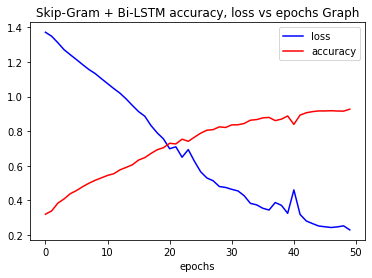

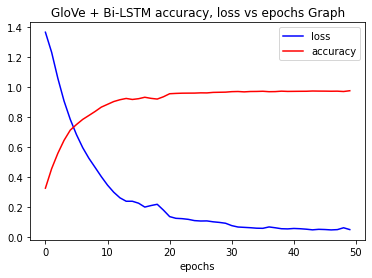

In [43]:
print("\tLstm\t\t\tBiLstm\t\t\tRnn")
print("sg",result_table[:3])
print("cbow",result_table[3:6])
print("glove",result_table[6:9])
print(history_sg_bi.history)
plt.title("Skip-Gram + Bi-LSTM accuracy, loss vs epochs Graph")
plt.plot(history_sg_bi.history['loss'],c='b',label='loss')
plt.plot(history_sg_bi.history['accuracy'],c='r',label='accuracy')
plt.xlabel('epochs')
plt.legend()
# plt.yticks()
plt.show()
plt.title("GloVe + Bi-LSTM accuracy, loss vs epochs Graph")
plt.plot(history_glove_bi.history['loss'],c='b',label='loss')
plt.plot(history_glove_bi.history['accuracy'],c='r',label='accuracy')
plt.xlabel('epochs')
plt.legend()
# plt.yticks()
plt.show()